<a href="https://colab.research.google.com/github/sid8123/Maxcut_qaoa/blob/main/maxcut_QAOA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit

     |████████████████████████████████| 8.5MB 4.9MB/s 
     |████████████████████████████████| 17.6MB 234kB/s 
     |████████████████████████████████| 204kB 45.5MB/s 
     |████████████████████████████████| 204kB 36.4MB/s 
     |████████████████████████████████| 2.1MB 38.9MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 1.0MB 36.3MB/s 
     |████████████████████████████████| 194kB 40.2MB/s 
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 583kB 28.0MB/s 
     |████████████████████████████████| 3.2MB 30.4MB/s 
     |████████████████████████████████| 5.5MB 32.5MB/s 
  Created wheel for qiskit: filename=qiskit-0.24.0-cp37-none-any.whl size=2918 sha256=54afedd36ff99209c536a92a6b944782be2e9b0c2860ab4c5ead6804260d0796
  Stored in directory: /root/.cache/pip/wheels/22/fe/0a/26b7a409d1a9c3698b0319c7d009a97bffaae392d755158dca
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2

The main moto of this problem is to seperate the whole set of nodes in two subsets $A$ and $B$ such that the sum of weights of edges that have different types of nodes at their ends become the maximum possible value. 

In other words, we have to find a partition through the whole graph, such that sum of weights of edges that the partition passes becomes the maximum among all possible cuts. 

We can convert this to a simple mathematical expression. 

>>>$C(z) = \sum \limits _{\alpha=1} ^{m} C_{\alpha}(z) $



Here $C(z)$ represents the score of a specific partition through the graph. $\alpha$ iterates from 1 to m where m is the number of edges present. for each edge, $C_{\alpha}(z)$ represents the score associated with each edge. $C_{\alpha}(z)$ is equal to the weight of the edge if the partition passes through that edge and equal to $0$, if not. 



As we have already defined a score value for a cut, we have to define that in terms of unitary ooperators that can be implemented on the quantum circuit. 

While representing the partition using computational basis states, we can represent the terms in $C(z)$ as operators acting on the states. 

>>> $C_{\alpha} = \frac{1}{2} W (1-\sigma_z^j \sigma_z^k) $

Here the $\alpha$th edge is the edge connecting $j$th and $k$th nodes. For each node $C_{\alpha}$ will be equal to the weight of the edge if the partition goes between $j$th and $k$th nodes and equal to $0$ if doesn't pass because the operator $(1-\sigma_z^j \sigma_z^k)$ has eigenvalue $1$, iff $j$th and $k$th qubit have different z-axis measurement values. 




Initially the circuit is converted to equal superposition state by applying Hadamard gate in each individual qubit, also known as $|+_{n}>$ state. 

The circuit consists of $L$ layers of $U_B$ and $U_C$ gates. In each layer, one $U_B$ and one $U_C$ is associated with one $\beta$ and $\gamma$ parameter. Therefore each layers having 2 params $\beta$ and $\gamma$, the whole $L$ layered circuit is consist of $2L$ parameters. 

Now coming to each of the layers, $U_B$ is single qubit operator, implemented on each of the individual qubits and it is basically a $R_X$ gate with parameter $2\beta$. $U_C$ whereas acts on two qubits. It is implemented on those two nodes who are connected by an edge in the graph. $U_C$ consists of a $R_Z$ gate with parameter $(-w\gamma)$ sandwitched between two CNOT gates. 


Random graph is generated from fast_gnp_random_graph() which takes the number of nodes, probability of edges and an initial seed as arguments

Max-cut instances are converted into Pauli list
Deal with Gset format. See https://web.stanford.edu/~yyye/yyye/Gset/
Design the max-cut object `w` as a two-dimensional np.array
e.g., w[i, j] = x means that the weight of a edge between i and j is x
Note that the weights are symmetric, i.e., w[j, i] = x always holds.

Here we generate an ising hamiltonian for the max cut problem using functions from max_cut ising model - qiskit.optimization.applications.ising.max_cut

For Hamiltonian generation :-
Input Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.

    Returns:
        WeightedPauliOperator: operator for the Hamiltonian
        float: a constant shift for the obj function.

At the end the max-cut value ( the number of edges in a max cut of a graph ) is output. Done by max_cut_value(x, w) function.

In [ ]:
import numpy as np
from qiskit.quantum_info import Pauli


from qiskit.optimization.applications.ising import max_cut

from qiskit.aqua.algorithms import QAOA
from qiskit.aqua.components.optimizers import *
from qiskit.aqua import QuantumInstance
import networkx as nx
from qiskit import Aer, execute

import networkx as nx

import time
import warnings

In [ ]:
def sample_most_likely(state_vector):
    if isinstance(state_vector, dict) or isinstance(state_vector, OrderedDict):
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x


def solve_ibmqx_ising_qubo(G, matrix_func, optimizer):
        backend = Aer.get_backend('qasm_simulator')
        w = matrix_func(G)
        ops, offset = max_cut.get_operator(w)
        qaoa = QAOA(ops, optimizer, quantum_instance=backend)
        result = qaoa.compute_minimum_eigenvalue()
        x = sample_most_likely(result.eigenstate)
        ising_sol = max_cut.get_graph_solution(x)
       
        return ising_sol


In [ ]:
def ibmqx4():
        G = nx.Graph()
        G.add_edge(0, 1)
        G.add_edge(2, 1)
        G.add_edge(2, 0)
        G.add_edge(3, 2)
        G.add_edge(2, 4)
        G.add_edge(3, 4)
        return G
def melbourne():
        G = nx.Graph()
        G.add_edge(0, 1)
        G.add_edge(1, 2)
        G.add_edge(13, 1)
        G.add_edge(13, 12)
        G.add_edge(12, 2)
        G.add_edge(2, 3)
        G.add_edge(11, 12)
        G.add_edge(11, 3)
        G.add_edge(4, 3)
        G.add_edge(11, 10)
        G.add_edge(4, 10)
        G.add_edge(5, 4)
        G.add_edge(9, 10)
        G.add_edge(5, 9)
        G.add_edge(5, 6)
        G.add_edge(9, 8)
        G.add_edge(6, 8)
        G.add_edge(7, 8)
        return G
def agave():
        G = nx.Graph()
        G.add_edge(0, 1)
        G.add_edge(1, 2)
        G.add_edge(2, 3)
        G.add_edge(3, 4)
        G.add_edge(4, 5)
        G.add_edge(5, 6)
        G.add_edge(6, 7)
        G.add_edge(7, 0)
        return G
def acorn():
        G = nx.Graph()
        G.add_edge(0, 5)
        G.add_edge(0, 6)
        G.add_edge(5, 10)
        G.add_edge(10, 15)
        G.add_edge(10, 16)
        G.add_edge(16, 11)
        G.add_edge(11, 17)
        G.add_edge(1, 6)
        G.add_edge(1, 7)
        G.add_edge(2, 7)
        G.add_edge(17, 12)
        G.add_edge(12, 18)
        G.add_edge(18, 13)
        G.add_edge(13, 19)
        G.add_edge(19, 14)
        G.add_edge(9, 14)
        G.add_edge(4, 9)
        G.add_edge(3, 9)
        G.add_edge(3, 8)
        G.add_edge(2, 8)
        G.add_edge(6, 11)
        G.add_edge(7, 12)
        G.add_edge(8, 13)
        return G
def aspen():
        G = nx.Graph()
        G.add_edge(6, 5)
        G.add_edge(5, 4)
        G.add_edge(4, 3)
        G.add_edge(3, 2)
        G.add_edge(2, 1)
        G.add_edge(1, 0)
        G.add_edge(0, 7)
        G.add_edge(7, 6)
        G.add_edge(15, 16)
        G.add_edge(16, 17)
        G.add_edge(17, 10)
        G.add_edge(10, 11)
        G.add_edge(11, 12)
        G.add_edge(13, 12)
        G.add_edge(13, 14)
        G.add_edge(15, 14)
        G.add_edge(2, 15)
        G.add_edge(1, 16)
        return G

In [ ]:
def maximum_clique_qubo_rigetti(G):
        lin = []
        quad = {}
        GC = nx.algorithms.operators.unary.complement(G)
        for i in list(G.nodes()):
                lin.append(-1)
        for a in list(GC.edges()):
                quad[a] = 2
        return lin, quad
def maximum_clique_qubo_dwave(G):
        Q = {}
        GC = nx.algorithms.operators.unary.complement(G)
        for i in list(G.nodes()):
                Q[(i, i)] = -1
        for a in list(GC.edges()):
                Q[a] = 2
        return Q

def maximum_cut_qubo_rigetti(G):
        quad = {}
        lin = []
        for a in list(G.edges()):
                quad[a] = 2
        for i in list(G.nodes()):
                lin.append(-1*G.degree(i))
        return lin, quad
def maximum_cut_qubo_dwave(G):
        Q = {}
        for a in list(G.edges()):
                Q[a] = 2
        for i in list(G.nodes()):
                Q[(i, i)] = -1*G.degree(i)
        return Q

def minimum_vertex_cover_qubo_rigetti(G):
	J = {}
	h = []
	for a in list(G.edges()):
		J[a] = 2
	for i in list(G.nodes()):
		h.append((-2*G.degree(i))+1)
	return h, J
def minimum_vertex_cover_qubo_dwave(G):
	Q = {}
	for a in list(G.edges()):
		Q[a] = 2
	for i in list(G.nodes()):
		Q[(i, i)] = ((-1*G.degree(i))-1)
	return Q
def max_cut_qubo_matrix_ibmqx(G):
        qubo = maximum_cut_qubo_dwave(G)
        data = np.zeros((len(G), len(G)))
        for a in qubo:
                data[a[0], a[1]] = qubo[a]
                data[a[1], a[0]] = qubo[a]
        return data

def minimum_vertex_cover_qubo_matrix_ibmqx(G):
        h, J = minimum_vertex_cover_qubo_rigetti(G)
        data = np.zeros((len(G), len(G)))
        for a in J:
                data[a[0], a[1]] = J[a]
                data[a[1], a[0]] = J[a]
        count = -1
        for i in h:
                count += 1
                data[count, count] = i
        return data

def max_clique_qubo_matrix_ibmqx(G):
        qubo = maximum_clique_qubo_dwave(G)
        data = np.zeros((len(G), len(G)))
        for a in qubo:
                data[a[0], a[1]] = qubo[a]
                data[a[1], a[0]] = qubo[a]
        return data

In [ ]:
def maximum_clique(G):
	return nx.algorithms.clique.graph_clique_number(G)
def maximum_independent_set(G):
	GC = nx.algorithms.operators.unary.complement(G)
	return nx.algorithms.clique.graph_clique_number(GC)
def minimum_vertex_cover(G):
        GC = nx.algorithms.operators.unary.complement(G)
        return len(G) - nx.algorithms.clique.graph_clique_number(GC)
def is_clique(G):
	n = len(G)
	m = len(G.edges())
	if m == ((n*(n-1))/2):
		return True
	else:
		return False
def max_cut_value(vector, G):
	count = -1
	subg1 = []
	subg2 = []
	for a in vector:
		count += 1
		if a == 1:
			subg1.append(count)
		if a != 1:
			subg2.append(count)
	H1 = G.subgraph(subg1)
	H2 = G.subgraph(subg2)
	m1 = len(H1.edges())
	m2 = len(H2.edges())
	val = len(G.edges())-(m1+m2)
	return val
def is_independent_set(vector, G):
        count = -1
        subg1 = []
        for a in vector:
                count += 1
                if a == 1:
                        subg1.append(count)
        H = G.subgraph(subg1)
        HC = nx.algorithms.operators.unary.complement(H)
        if is_clique(HC) == True:
                return True
        else:
                return False
def list_difference(list1, list2):
	out = []
	for a in list1:
		if a not in list2:
			out.append(a)
	return out
def is_vertex_cover(vector, G):
        count = -1
        subg1 = []
        for a in vector:
                count += 1
                if a == 1:
                        subg1.append(count)
        list1 = list(G.nodes())
        mis_subg = list_difference(list1, subg1)
        H = G.subgraph(mis_subg)
        HC = nx.algorithms.operators.unary.complement(H)
        if is_clique(HC) == True:
                return True
        else:
                return False
def subg_is_clique(list, G):
	count = -1
	mc = []
	for i in list:
		count += 1
		if i == 1:
			mc.append(count)
	H = G.subgraph(mc)
	if is_clique(H) == True:
		return True
	else:
		return False

maxcut

55
55.0
[55]
--- 20.576923608779907 seconds ---


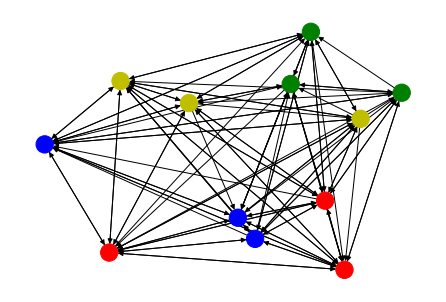

In [ ]:
start_time = time.time()

warnings.filterwarnings("ignore")

def ibqmx_qaoa(G, optimizer, func):
        app_ratio = 0
        qubo_main = []
        counter = 0
        for avg in range(0, 100):
            counter += 1
            result_out = solve_ibmqx_ising_qubo(G, func, optimizer)
            result2 = []
            for i in result_out:
                  if i == 0:
                        result2.append(1)
                  if i == 1:
                        result2.append(0)
            x = max_cut_value(result2, G)
            print(x)
            qubo_main.append(x)
            app_ratio += x
            print(float(app_ratio)/float(counter))
            return x

print('maxcut')
out = []
for r in range(1, 2):
    #G = nx.fast_gnp_random_graph(7, 0.5, 101)
    num_nodes = 12
    G = nx.fast_gnp_random_graph(num_nodes, 0.8, 10, 48)
    #G = nx.from_numpy_matrix(w)
    layout = nx.random_layout(G, seed=10)
    colors = ['r', 'g', 'b', 'y', 'r','g', 'b', 'y', 'r', 'g', 'b', 'y']
    nx.draw(G, layout, node_color=colors)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);
    print(G)
    res = ibqmx_qaoa(G, SLSQP(), max_cut_qubo_matrix_ibmqx)
    out.append(res)
    print(out)
print("--- %s seconds ---" % (time.time() - start_time))